<img src="https://github.com/FUlyankin/HSE_Data_Culture/blob/master/ML_for_marketing_2019/sems/sem9_clasters/embedding.gif?raw=true" height="500" width="500"> 

# <center> ML для маркетинга. <br>  <br> Cюжетная арка 3: сегментация </center>

В этом семестре мы с вами пройдём через несколько сюжетных арок. Третьей и заключительной такой аркой будет сегментация. 


#  Глава I (Люси заглядывает в платяной шкаф) 

## 1. Постановка задачи 

Представим, что международное круизное агентство "Carnival Cruise Line" решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой, и агентство продолжило с Вами сотрудничать.

Агентство крупное, и у него есть офисы по всему миру. Вблизи этих офисов оно и хочет разместить баннеры - легче договариваться и проверять результат. Также эти места должны хорошо просматриваться. Подумайте как бы вы решали эту задачу. Откуда бы вы взяли данные и какие? __Сначала подумайте, а после читайте блокнот дальше. Там ответы...__


## 2. Ход мыслей

Примерный ход ваших мыслей должен был выглядеть так: 

- Банеры. Нужно, чтобы их чаще смотрели. В точках, где они стоят нужны большие скопления людей. 
- Как найти большое скопление людей? По геолокации! Нужна база чекинов. 
- Тогда мы сможем кластеризовать чекины, найти самые популярные места в окрестнсоти каждого офиса и поставить там банеры. Задача будет решена, на банеры будут смотреть, а нам дадут денег. 


## 3. Учим машины и рисуем карты

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях - Foursqare. Часть открытых данных есть, например, на сайте [archive.org.](https://archive.org/details/201309_foursquare_dataset_umn) Нас будет интересовать файл `checkins.dat`. Подгрузим его и посмотрим, что лежит внутри. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('hw6/checkins.csv')
print('Размер выборки:', df.shape)
df.head()

Размер выборки: (396634, 6)


,id,user_id,venue_id,latitude,longitude,created_at
0,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
1,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
2,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
3,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
4,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


Внутри лежат  id наблюдений, id тех, кто зачекинился, время чекина, ещё какое-то id и координаты чекина. Именно координаты нас и интересуют. Заберём их в отдельную таблицу $X.$

In [4]:
X = df[['longitude', 'latitude']]
X.head()

,longitude,latitude
0,-77.036366,38.895112
1,-84.410520,33.800745
2,-122.676207,45.523452
3,-111.904565,40.764462
4,-112.074037,33.448377


Как мы помним, 20 баннеров надо разместить около офисов компании. Если воспользоваться Google Maps, можно узнать координаты этих офисов.

```
33.751277, -118.188740 (Los Angeles)

25.867736, -80.324116 (Miami)

51.503016, -0.075479 (London)

52.378894, 4.885084 (Amsterdam)

39.366487, 117.036146 (Beijing)

-33.868457, 151.205134 (Sydney)
```

In [5]:
# координаты офисов
ofices = np.array([[-118.188740, 33.751277],[-80.324116, 25.867736], [-0.075479, 51.503016],
                  [4.885084, 52.378894], [117.036146, 39.366487], [151.205134, -33.868457]])

Посмотрим как расположение офисов и чекинов выглядит на картинке и попробуем догадаться где какой материк.

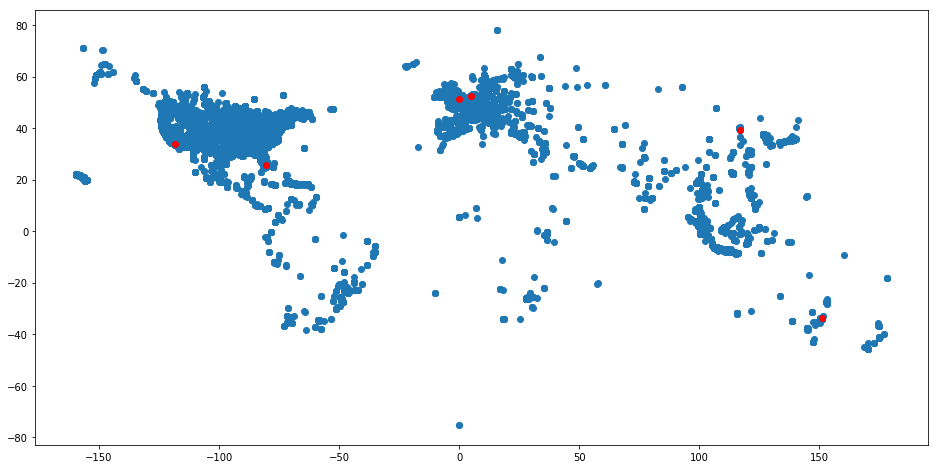

In [6]:
plt.figure(figsize=(16,8))
plt.scatter(X.longitude.values,X.latitude.values)
plt.scatter(ofices[:,0], ofices[:,1], color='red')

## 4. Кластеризация

Пришло время разбивать чекины на однородные группы. Будем делать это с помощью кластеризации. 

**Примечание**: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико, чтобы не повлиять на кластеризацию или сортировку.

**Примечание**: на 396632 строках, кластеризация будет работать долго. Для получения корректного ответа достаточно и 100000 (~2 минуты на "среднем" ноутбуке). Быть очень терпеливым не возбраняется - результат от этого только улучшится. Если 100000 компьютер тоже отказывается тянуть, возьмите более мелкую выборку. 

Сделаем сэмпл. 

In [7]:
ind = np.random.choice(range(X.shape[0]), 100000)
X_sample = X.get_values()[ind]
X_sample.shape

(100000, 2)

__[1]__ Для начала попробуем сделать кластеризацию методом K-means на два кластера. 

In [8]:
%%time
from sklearn.cluster import KMeans
kmeanModel = KMeans(n_clusters=50)
kmeanModel.fit(X_sample)

CPU times: user 12.7 s, sys: 3.83 s, total: 16.5 s
Wall time: 5.69 s


In [9]:
centers = kmeanModel.cluster_centers_ #запишите сюда центры кластеров 
centers

array([[-111.9001355 ,   33.39752641],
       [ 107.10559991,   -6.35062898],
       [ -74.08037445,   40.69555798],
       [   0.23467543,   51.53205742],
       [ -89.63277317,   30.36219624],
       [ -87.61173397,   41.95408041],
       [-122.14811109,   37.72223622],
       [ -46.51146182,  -22.95518107],
       [ 148.35590927,  -34.52260496],
       [  36.86647426,   -0.42263014],
       [ -80.37394749,   25.92717723],
       [ 117.52867446,   20.06410732],
       [-122.36849411,   47.18499531],
       [ -97.97141408,   29.93962859],
       [-117.93144562,   33.7442415 ],
       [-157.60023769,   21.16831136],
       [-105.52128927,   33.74101188],
       [  67.713761  ,   21.92176377],
       [ -76.99729016,   38.87654107],
       [  12.03738821,   49.89896753],
       [ -84.75166243,   34.26396227],
       [ 139.021231  ,   35.51336122],
       [ -93.42799257,   44.98467238],
       [-115.14369905,   36.09280164],
       [-148.02614198,   61.8745885 ],
       [ 100.18705538,   

In [10]:
labels = kmeanModel.labels_ # запишите сюда лэйблы кластеров (единичка или нолик) 
labels[:10]

array([ 2, 26, 14, 35, 37, 26,  2,  0,  2, 20], dtype=int32)

Запустите код ниже. Построится карта, где все точки будут покрашены в соотвествующие кластеры.

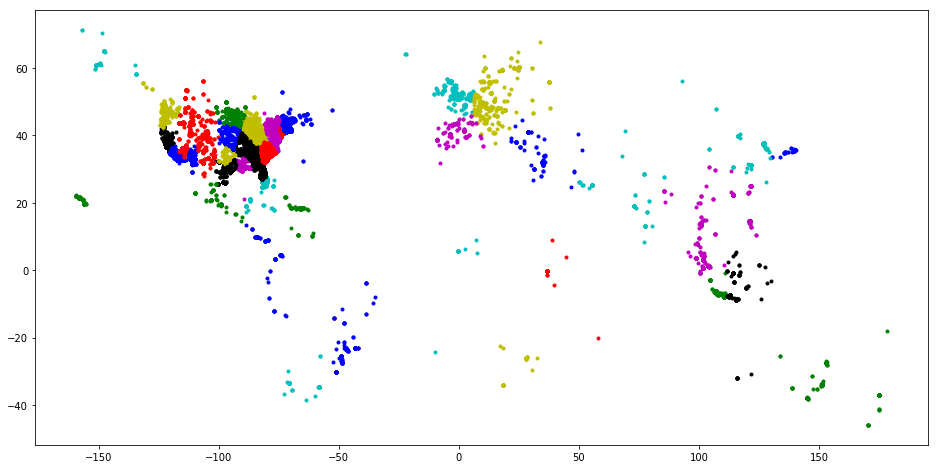

In [11]:
from itertools import cycle

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(figsize=(16,8))

# Будем перебирать все цвета внутри вот этого цикла
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    center = centers[k]
    # Каждый кластер наносим на график своим цветом 
    plt.plot(X_sample[my_members,0],X_sample[my_members,1],col + '.' )

__[1]__ Попробуйте оценить k-means c 4, 5, 10, 20, 50 кластерами. Каждый раз просто перезапускайте код выше с новым числом $K$. Что происходит с точками на карте? Как именно чекины разбиваются на сегменты? Есть ли что-то плохое в таком поведении алгоритма для нашей задачи? 

__Ответ:__ 

- Точки дробятся на кластеры. Чем больше K, тем больше кластеров
- Судя по всему кластеры выстраиваются в соотвествии с границами стран или штатов, это не очень хорошо, непонятно как можно поставить рекламный щит в середине страны 
- Кластеры оказываются разного размера, а нам хотелось бы, чтобы для каждого банера по площади кластеры были одинаковыми, так как хочется одинаковой видимости, а не один банер на всю Францию с непонятно какой видимостью

Давайте попробуем теперь реализовать на наших данных немного другой алгоритм. Он называется DBSCAN. Пока что мы о нём ничего не знаем и понятия не имеем как он работает. 

__[1]__  Разберитесь как работает этот алгоритм и опишите интуицию которая за ним стоит. Математику опустите. В описании интуиции вам поможет [вот эта статья.](https://habr.com/ru/post/322034/)

__Ответ:__ 

- В статье на Хабре всё написано очень хорошо. Не вижу смысла копировать сюда тот же текст. 


__[1]__ Ну а теперь реализуйте алгоритм на наших данных. Написать несколько волшебных строк для этого вам поможет [документация к sklearn.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) Обоснуйте свой выбор параметров алгоритма (параметры `eps` и `min_samples`).


__Рассуждения:__

Тут хотелосб увидеть что-то аналогичное рассуждениям, связанным с MeanShift, которые были ниже по тетрадке:

> И такой алгоритм, действительно есть! Он называется MeanShift. Его описание при желании можно посмотреть в sklearn user guide. В этом алгоритме можно искуственно ограничить радиус каждого кластера с помощью специальной опции bandwidth. Укажем bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

Например: 

- 0.1 градус это примерно 5-10 км в средних широтах
- epsilon отвечает за максимальную дистанцию между двумя точками в рамках одного кластера. Было бы неплохо, если бы внутри кластера точки находились не очень далеко друг от друга, это позволит выделить наиболее плотные сгустки. Если поставим 0.01, то мы разрешим расстояние между точками 500 метров - 1 км. Наверное, можно отнести такие чекины к одному туристическому объекту. В принципе можно взять ещё меньше. 
- min_samples минимальное число чекинов в кластере, давайте возьмём 10, чтобы избавиться от маргинальных кластеров по 1-2-3 наблюдения. 




In [18]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.01, min_samples=10).fit(X_sample)

In [19]:
labels = clustering.labels_ # запишите сюда лэйблы кластеров 

Давайте посмотрим что у нас получится на карте. 

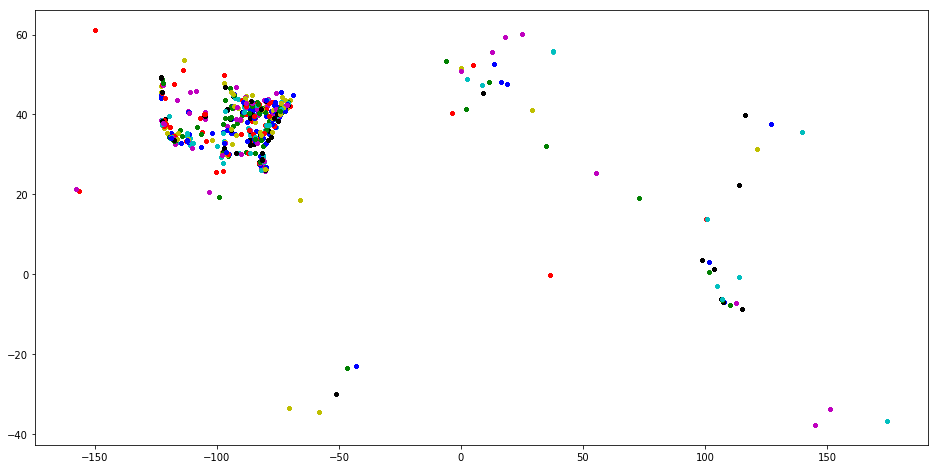

In [20]:
from itertools import cycle

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(figsize=(16,8))

# Будем перебирать все цвета внутри вот этого цикла
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    # Каждый кластер наносим на график своим цветом 
    plt.plot(X_sample[my_members,0],X_sample[my_members,1],col + '.' )

__[1]__  Сколько получилось кластеров? 

In [21]:
labels_unique = np.unique(labels)
len(labels_unique)

1117

Что такое $-1$ кластер? Какой в нём смысл (чтобы ответить на этот вопрос надо было почитать про алгоритм...) 

__Ответ:__  Это кластер из точек, которые алгоритм отнес к шуму. В хабре таких людей называли отшельниками.

Сколько в него попало точек? 

In [22]:
np.sum(labels == -1)

15063

In [23]:
# ради интереса размеры кластеров
from collections import Counter
cnt = Counter(labels) # посчитали

In [27]:
cnt.most_common()[:20] # 20 крупнейших кластеров

[(-1, 15063),
 (0, 6115),
 (23, 4985),
 (12, 3864),
 (64, 2725),
 (54, 2117),
 (52, 1980),
 (78, 1510),
 (47, 1457),
 (34, 1180),
 (4, 1161),
 (56, 1138),
 (5, 1084),
 (30, 1081),
 (83, 1081),
 (26, 1068),
 (6, 1060),
 (8, 1055),
 (89, 944),
 (19, 934)]

__[1]__ Как думаете, подходит ли DBSCAN для решения нашей задачи? У него явно есть какие-то минусы, которые конфликтуют с бизнец-целью, поставленной перед нами. Что это за минусы? 

__Ответ:__  

- Из-за логичного подбора параметров кластеры получилсь довольно компактными, а не размером в страну 
- Тем не менее они очень разные по размерам и обладают разной зоной видимости
- Иногда между кластерами возникают "мосты", более того кластеры бывают очень странной формы и из-за этого сложно понять где у него центр и куда пихать щит, в отличие от выпуклых кластеров в k-means


Это всё, конечно, круто, но баннеры имеют сравнительно небольшую площадь действия. Кластеры, которые мы получили выше оказались какими-то слишком большими. Хочется найти какой-то алгоритм, который позволяет ограничить размер кластера. Он должен не зависеть от их числа.  

И такой алгоритм, действительно есть! Он называется `MeanShift`. Его описание при желании можно посмотреть в [sklearn user guide.](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)  В этом алгоритме можно искуственно ограничить радиус каждого кластера с помощью специальной опции `bandwidth`. Укажем `bandwidth=0.1`, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.


__[2]__  Подгрузете `MeanShift` из `sklearn` и запустите его на наших данных. Установите параметры `bin_seeding=True` и `min_bin_freq=15`. За что отвечают эти параметры? (ответ ищите в документации)

__Ответ:__ 

- bin_seeding делает более умную инициализацию начальных координат, он их кидает не в рандомные места по всей карте, а ставит в соотвествии с сеткой, которая накладывается на данные. В каждой ячейке заданного радиуса сетки по одной, инициализированной случайно, точке. Из-за этого работа алгоритма ускоряется и становится более стабильной. 
- min_bin_freq  минимальное число точек в кластере

In [28]:
%%time
from sklearn import cluster
clt = cluster.MeanShift(bandwidth=0.1, bin_seeding=True, min_bin_freq=15)
clt.fit(X_sample)

CPU times: user 2.38 s, sys: 24 ms, total: 2.4 s
Wall time: 2.41 s


Сколько всего кластеров выделила модель? 

In [30]:
labels = clt.labels_           # запишите сюда лэйблы кластеров 
centers = clt.cluster_centers_ # запишите сюда координаты центров кластеров

In [44]:
labels_unique = np.unique(labels)
len(labels_unique)

525

Посмотрим на то, как наши кластеры выглядят на карте мира!

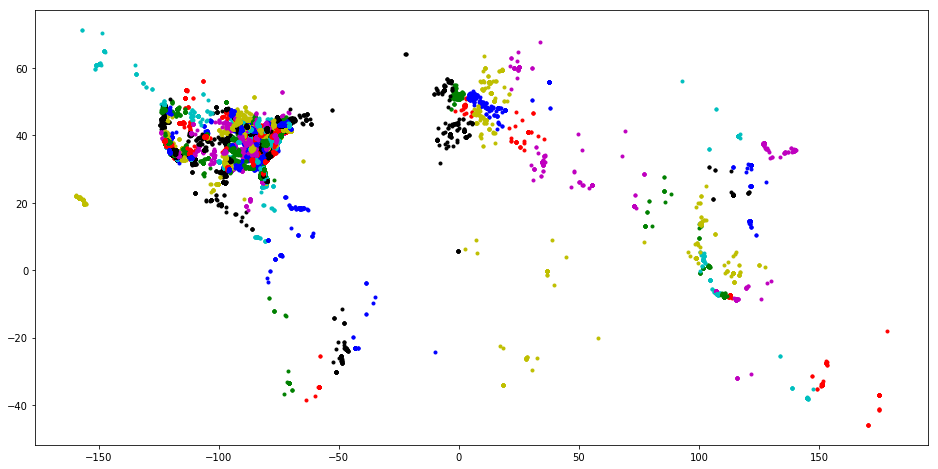

In [31]:
from itertools import cycle

labels = clt.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(figsize=(16,8))

# Будем перебирать все цвета внутри вот этого цикла
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    center = centers[k]
    # Каждый кластер наносим на график своим цветом 
    plt.plot(X_sample[my_members,0],X_sample[my_members,1],col + '.' )

Каждый кластер нанесён на карту своим цветом. Красота! Давайте построим точно такую же картинку, но ещё и с центрами кластеров.

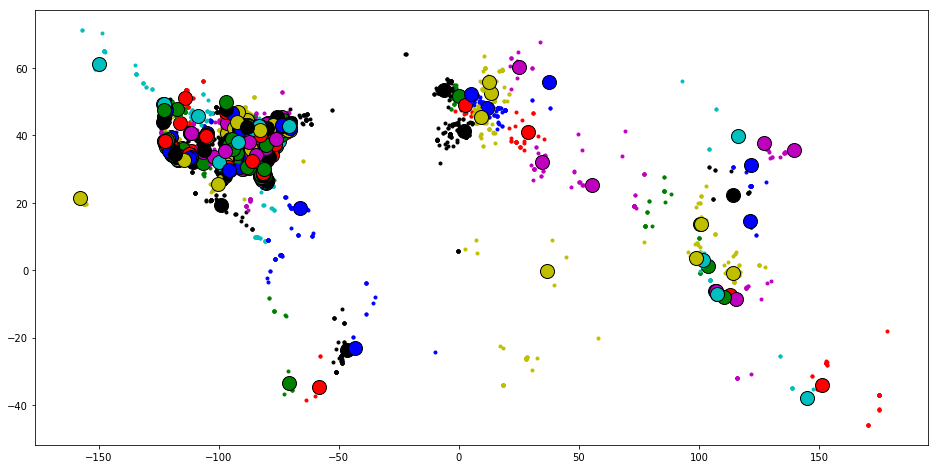

In [32]:
plt.figure(figsize=(16,8))

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    center = centers[k]
    
    # Каждый кластер наносим на график своим цветом 
    plt.plot(X_sample[my_members,0],X_sample[my_members,1],col + '.' )
    
    # Выделяем у кластеров центры 
    plt.plot(center[0], center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

Мы немного отвлеклись на картинки. Давайте вернёмся к нашей задаче. Мы должны выбрать 20 самых близких к офисам точек. 

__[2]__ Давайте найдём такие точки. Для этого отсортируем центры кластеров по расстояниям до каждого офиса. 

In [35]:
results = [ ]
for item in ofices:
    for jtem in centers:
        cur_rast = float(np.linalg.norm(jtem - item, ord=2))
        trio = (cur_rast, jtem, item)
        results.append(trio)

In [36]:
# внутри results лежат тройки (расстояние, координаты центра кластера, координаты офиса)
results[0]  

(44.74523564113067,
 array([-73.98909905,  40.71747055]),
 array([-118.18874 ,   33.751277]))

In [37]:
# всего у нас есть вот столько вариантов расположить рекламные щиты
len(results)

3150

Возьмём 20 самых близких офисов.

In [38]:
results.sort()         # отсортировали по расстоянию
best_20 = results[:20] # взяли 20 самых близких
best_20[:5]

[(0.0008954485630227557,
  array([151.20576287, -33.86909445]),
  array([151.205134, -33.868457])),
 (0.00951308196653971,
  array([ 4.89243261, 52.37285275]),
  array([ 4.885084, 52.378894])),
 (0.05260627961959159,
  array([-0.12808514, 51.50289598]),
  array([-0.075479, 51.503016])),
 (0.06549270279681314,
  array([-118.15150048,   33.80515197]),
  array([-118.18874 ,   33.751277])),
 (0.13356581011514446,
  array([-80.21735113,  25.78747961]),
  array([-80.324116,  25.867736]))]

In [39]:
# Распакуем координаты для строительства картинки 
coord = np.array([[item[1][0],item[1][1]] for item in best_20])

In [40]:
coord[:5] # координаты распаковались :) 

array([[ 1.51205763e+02, -3.38690945e+01],
       [ 4.89243261e+00,  5.23728528e+01],
       [-1.28085143e-01,  5.15028960e+01],
       [-1.18151500e+02,  3.38051520e+01],
       [-8.02173511e+01,  2.57874796e+01]])

Строим ещё картинку! Красным нанесём офисы, лиловым точки для рекламы. Из-за больших масштабов, точки наложились друг на друга.

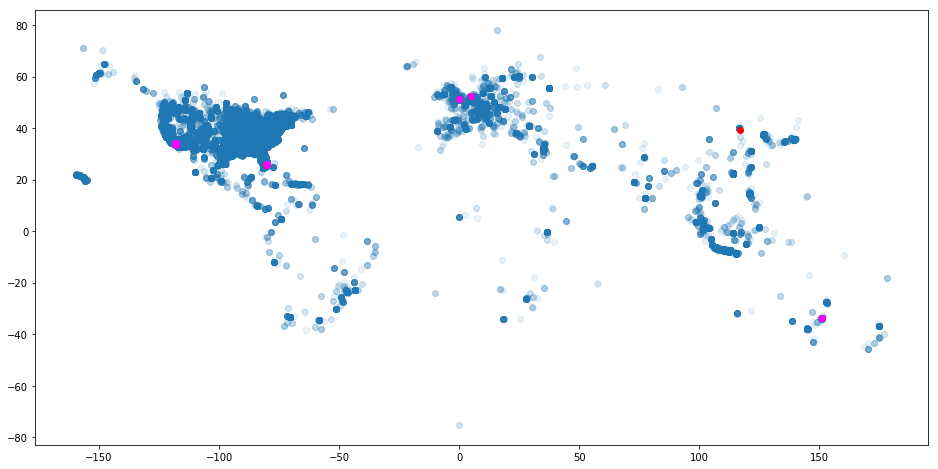

In [41]:
plt.figure(figsize=(16,8))
plt.scatter(X.longitude.values,X.latitude.values, alpha=0.1)  # Наносим все чекины
plt.scatter(ofices[:,0], ofices[:,1], color='red')            # Наносим офисы 
plt.scatter(coord[:,0], coord[:,1], color='magenta')          # Наносим точки для рекламы 

Посмотрим в окрестностях какого офиса оказалась большая часть баннеров.

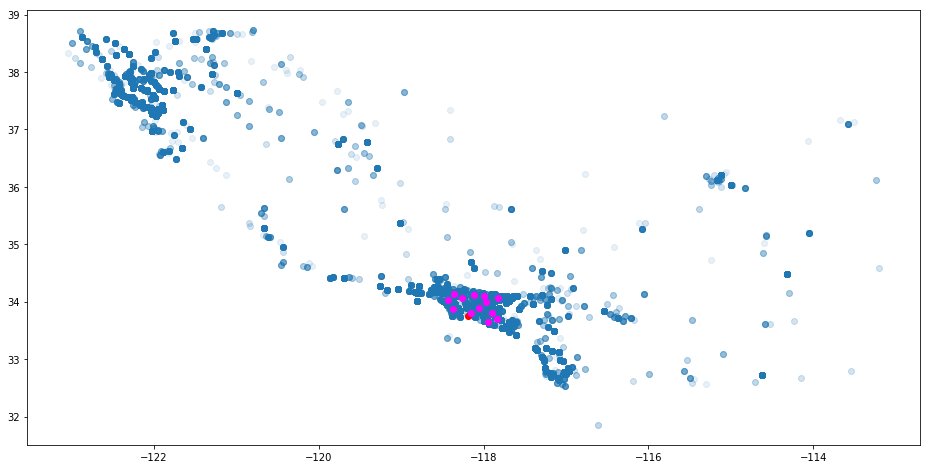

In [42]:
l = 5
с_long = -118.18874
c_lat = 33.751277

X_int = X[(X.longitude > с_long - l)&(X.longitude < с_long + l)& 
          (X.latitude >  - l)&(X.latitude < c_lat + l)]
    
coord_int = coord[(coord[:,0] > с_long - l)&(coord[:,0] < с_long + l)& 
                  (coord[:,1] > c_lat - l)&(coord[:,1] < c_lat + l)]    


ofices_int = ofices[(ofices[:,0] > с_long - l)&(ofices[:,0] < с_long + l)& 
                    (ofices[:,1] > c_lat - l)&(ofices[:,1] < c_lat + l)] 

plt.figure(figsize=(16,8))
plt.scatter(X_int.longitude.values,X_int.latitude.values, alpha=0.1)  # Наносим все чекины
plt.scatter(ofices_int[:,0], ofices_int[:,1], color='red')            # Наносим офисы 
plt.scatter(coord_int[:,0], coord_int[:,1], color='magenta')          # Наносим точки для рекламы 

Это Калифорния! 

__[дополнительные 5 баллов]__ Компании безумно понравился наш алгоритм! Она просит нас внести небольшую правку. Ребята согласны пожертвовать близостью щита к офису в пользу большего числа чекинов, то есть в пользу большей просматриваемости. 

Найдите $20$ самых близких к офисам точек с более, чем $100$ чекинами. Нарисуйте их на карте. 

In [ ]:
# Оставим только те кластеры, где больше 100 чекинов. 



In [58]:
from collections import Counter

labels = clt.labels_    # запишите сюда лэйблы кластеров 
cnt = Counter(labels)   # посчитали  и получили словарик {кластер: число эдементов в нем} 

cnt[15] # например, в 15 кластере 1099 элеентов

1099

In [48]:
cnt.most_common()[:20] # самые крупные кластеры 

[(0, 14204),
 (1, 3868),
 (2, 2857),
 (4, 2739),
 (3, 2305),
 (6, 2089),
 (7, 1786),
 (5, 1709),
 (8, 1643),
 (9, 1464),
 (12, 1243),
 (11, 1230),
 (14, 1115),
 (15, 1099),
 (13, 1070),
 (10, 1015),
 (16, 949),
 (21, 836),
 (19, 834),
 (24, 786)]

In [53]:
# профильтровали номера кластеров, в которых больше 100 чекинов
labels_100 = [item[0] for item in cnt.most_common() if item[0] >= 100]

# отсоритруем номера по возрастанию
labels_100 = sorted(labels_100)

In [54]:
len(labels_100) # таких 425 (выше было больше 3000)

425

Прделаем ровно то же самое, что и выше, но только по отобранным кластерам. 

In [60]:
centers = clt.cluster_centers_ # запишите сюда координаты центров кластеров

centers_100 = centers[np.array(labels_100)]  # срежем только наши кластеры из labels_100

In [61]:
results = [ ]
for item in ofices:
    for jtem in centers_100:
        
        cur_rast = float(np.linalg.norm(jtem - item, ord=2))
        trio = (cur_rast, jtem, item)
        results.append(trio)

In [62]:
results.sort()         # отсортировали по расстоянию
best_20 = results[:20] # взяли 20 самых близких
best_20[:5]

[(0.0008954485630227557,
  array([151.20576287, -33.86909445]),
  array([151.205134, -33.868457])),
 (0.00951308196653971,
  array([ 4.89243261, 52.37285275]),
  array([ 4.885084, 52.378894])),
 (0.3287236398130062,
  array([-117.97716216,   34.00286009]),
  array([-118.18874 ,   33.751277])),
 (0.3435552878333461,
  array([-80.24547694,  26.20217005]),
  array([-80.324116,  25.867736])),
 (0.40258487607277327,
  array([-117.99742903,   34.10550107]),
  array([-118.18874 ,   33.751277]))]

In [63]:
# Распакуем координаты для строительства картинки 
coord = np.array([[item[1][0],item[1][1]] for item in best_20])

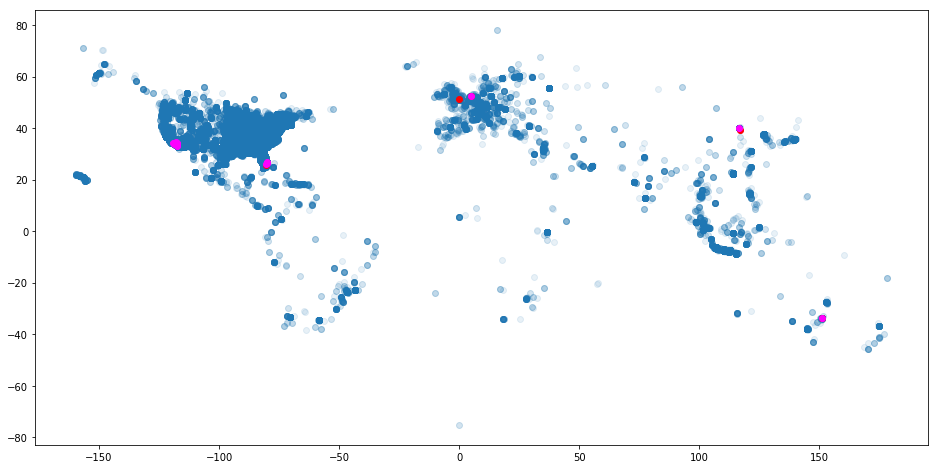

In [64]:
plt.figure(figsize=(16,8))
plt.scatter(X.longitude.values,X.latitude.values, alpha=0.1)  # Наносим все чекины
plt.scatter(ofices[:,0], ofices[:,1], color='red')            # Наносим офисы 
plt.scatter(coord[:,0], coord[:,1], color='magenta')          # Наносим точки для рекламы 

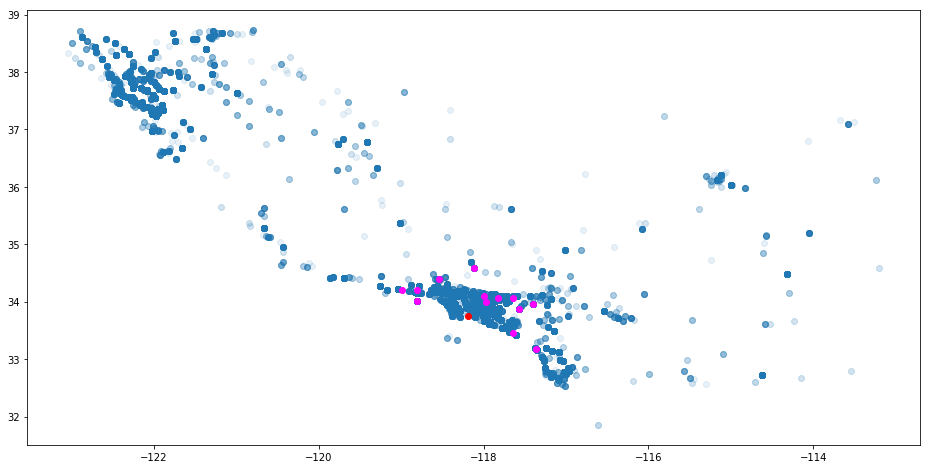

In [65]:
l = 5
с_long = -118.18874
c_lat = 33.751277

X_int = X[(X.longitude > с_long - l)&(X.longitude < с_long + l)& 
          (X.latitude >  - l)&(X.latitude < c_lat + l)]
    
coord_int = coord[(coord[:,0] > с_long - l)&(coord[:,0] < с_long + l)& 
                  (coord[:,1] > c_lat - l)&(coord[:,1] < c_lat + l)]    


ofices_int = ofices[(ofices[:,0] > с_long - l)&(ofices[:,0] < с_long + l)& 
                    (ofices[:,1] > c_lat - l)&(ofices[:,1] < c_lat + l)] 

plt.figure(figsize=(16,8))
plt.scatter(X_int.longitude.values,X_int.latitude.values, alpha=0.1)  # Наносим все чекины
plt.scatter(ofices_int[:,0], ofices_int[:,1], color='red')            # Наносим офисы 
plt.scatter(coord_int[:,0], coord_int[:,1], color='magenta')          # Наносим точки для рекламы 

Снова калифорния, но расположение точек уже немного другое! 

## 4. Подводим итоги

Итак, мы только что помогли выбрать круизному агенству просматриваемые и близкие к офисам точки для рекламы. В ходе решения задачи: 

- Мы выслушали заказчика и поняли какие есть ограничения.
- Мы придумали откуда взять данные и как по ним найти популярные места. 
- Мы нашли подходящий алгоритм кластеризации и обучили модель.
- Мы подыскали самые просматриваемые локации в окрестности офисов. 
- Мы клёвые и заслужили гору бабла. 

Осталось только нарисовать красивую презентацию и показать это добро "Carnival Cruise Line". 